### [1] 패키지 불러오기 

In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image

### [2] Data transform 정의

In [ ]:
import torchvision.transforms as transforms

# 사이즈 설정
size = [230, 230]
center_size = [224, 224]

# 학습용 Transform
TrainTransform = transforms.Compose([
    transforms.Resize(size),
    transforms.CenterCrop(center_size),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 검증/테스트용 Transform
ValidTransform = transforms.Compose([
    transforms.Resize(size),
    transforms.CenterCrop(center_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


### [3] Eye dataset 클래스

In [ ]:
import os
import json
from PIL import Image
from torch.utils.data import Dataset
import torch

class NewEyeDataset(Dataset):
    def __init__(self, data, image_path, transform=None):
        self.data = data
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        left_img = Image.open(os.path.join(self.image_path, item['left_eye'])).convert('RGB')
        right_img = Image.open(os.path.join(self.image_path, item['right_eye'])).convert('RGB')

        if self.transform:
            left_img = self.transform(left_img)
            right_img = self.transform(right_img)

        label = torch.tensor(item['label'], dtype=torch.long)

        return left_img, right_img, label

    @classmethod
    def from_json(cls, json_file, image_path, group_value=1, include_0_9mm=True, transform=None):
        with open(json_file, 'r') as f:
            raw_data = json.load(f)

        usable_data = [
            item for item in raw_data.values()
            if item['group'] == group_value and (include_0_9mm or item['thickness'] != 0.9)
        ]

        print(f"usable samples for group {group_value}: {len(usable_data)}")
        return cls(usable_data, image_path, transform)


### [4] 구글 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### [5] train_loader, val_loader, test_loader 구성

In [ ]:
from torch.utils.data import DataLoader

# 경로 설정
json_path = '/content/drive/MyDrive/cv_project/dataset/data_info.json'
image_path = '/content/drive/MyDrive/cv_project/dataset/train_images/Fundus_CIMT_2903 Dataset'

# 데이터셋 생성
train_dataset = NewEyeDataset.from_json(json_file=json_path, image_path=image_path, group_value=1, transform=TrainTransform)
val_dataset = NewEyeDataset.from_json(json_file=json_path, image_path=image_path, group_value=2, transform=ValidTransform)
test_dataset = NewEyeDataset.from_json(json_file=json_path, image_path=image_path, group_value=3, transform=ValidTransform)

# 최적화된 데이터로더
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)


usable samples for group 1: 2603
usable samples for group 2: 200
usable samples for group 3: 100


### [6] SiameseSeResNeXtdropout 모델 정의

In [ ]:
import torch
import torch.nn as nn
import timm

class SiameseSeResNeXtdropout(nn.Module):
    def __init__(self):
        super(SiameseSeResNeXtdropout, self).__init__()
        # backbone 변경: seresnext50_32x4d.racm_in1k
        self.backbone = timm.create_model('seresnext50_32x4d.racm_in1k', pretrained=True, num_classes=0)

        # backbone feature dimension은 2048 → 두 개 concatenate하면 4096
        self.dropout = nn.Dropout(0.5)

        self.classifier = nn.Sequential(
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2)  # Binary classification (Normal / Thickened)
        )

    def forward(self, left, right):
        left_feat = self.backbone(left)    # (batch, 2048)
        right_feat = self.backbone(right)  # (batch, 2048)

        combined = torch.cat((left_feat, right_feat), dim=1)  # (batch, 4096)
        combined = self.dropout(combined)  # backbone feature 뒤에 dropout(0.5)

        output = self.classifier(combined)

        return output


### [7] FocalLoss 클래스 정의

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * CE_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


### [8] 학습 루프 + loss 그래프

In [ ]:
import matplotlib.pyplot as plt

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 초기화
model = SiameseSeResNeXtdropout().to(device)

# 손실 함수
criterion = FocalLoss()

# 옵티마이저 (AdamW)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# 학습률 스케줄러
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# 하이퍼파라미터
epochs = 50
best_val_loss = float('inf')

# 손실 저장 리스트
train_losses = []
val_losses = []

# 학습 루프
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for left, right, labels in train_loader:
        left, right, labels = left.to(device), right.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(left, right)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for left, right, labels in val_loader:
            left, right, labels = left.to(device), right.to(device), labels.to(device)

            outputs = model(left, right)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_accuracy = correct / total
    train_loss = running_loss / len(train_loader)
    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    scheduler.step()

    # Best 모델 저장 (loss 기준)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/cv_project/01unimodal/best_unimodal_model.pth')
        print(f"Best model updated at epoch {epoch+1} (Val Loss: {best_val_loss:.4f})")

    # 출력
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

# 딕셔너리로 정리
loss_history = {
    'train_loss': train_losses,
    'val_loss': val_losses
}

# JSON으로 저장
with open('/content/drive/MyDrive/cv_project/01unimodal/loss_history.json', 'w') as f:
    json.dump(loss_history, f, indent=2)

print("loss_history.json 저장 완료!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/111M [00:00<?, ?B/s]

Best model updated at epoch 1 (Val Loss: 0.1804)
Epoch 1/50 | Train Loss: 0.1415 | Val Loss: 0.1804 | Val Acc: 0.5000 | LR: 0.001000
Epoch 2/50 | Train Loss: 0.1296 | Val Loss: 0.1815 | Val Acc: 0.6450 | LR: 0.001000
Epoch 3/50 | Train Loss: 0.1240 | Val Loss: 0.1806 | Val Acc: 0.6350 | LR: 0.001000
Best model updated at epoch 4 (Val Loss: 0.1436)
Epoch 4/50 | Train Loss: 0.1243 | Val Loss: 0.1436 | Val Acc: 0.7350 | LR: 0.001000
Epoch 5/50 | Train Loss: 0.1208 | Val Loss: 0.1577 | Val Acc: 0.6900 | LR: 0.001000
Epoch 6/50 | Train Loss: 0.1261 | Val Loss: 0.3222 | Val Acc: 0.6650 | LR: 0.001000
Epoch 7/50 | Train Loss: 0.1275 | Val Loss: 0.1544 | Val Acc: 0.6950 | LR: 0.001000
Epoch 8/50 | Train Loss: 0.1222 | Val Loss: 0.1546 | Val Acc: 0.6650 | LR: 0.001000
Epoch 9/50 | Train Loss: 0.1219 | Val Loss: 0.2071 | Val Acc: 0.6950 | LR: 0.001000
Epoch 10/50 | Train Loss: 0.1207 | Val Loss: 0.1633 | Val Acc: 0.6850 | LR: 0.001000
Epoch 11/50 | Train Loss: 0.1187 | Val Loss: 0.1451 | Val Acc

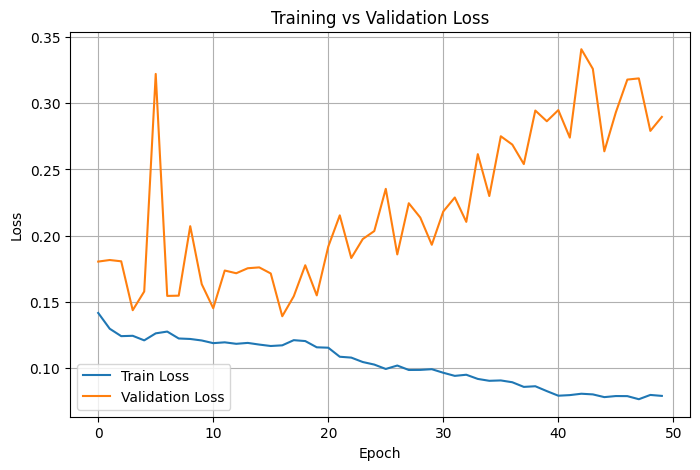

In [ ]:
# 학습 종료 후 그래프 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

### [9] predict_result.json 저장

In [ ]:
from tqdm import tqdm

# 테스트셋 로드 (이미 test_loader는 있음)

# 모델 로드
model = SiameseSeResNeXtdropout().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/cv_project/01unimodal/best_unimodal_model.pth'))
model.eval()

# 예측 수행
results = []
with torch.no_grad():
    for left, right, labels in tqdm(test_loader, desc="Predicting"):
        left, right = left.to(device), right.to(device)
        outputs = model(left, right)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        for true, pred, prob in zip(labels.cpu(), preds.cpu(), probs[:, 1].cpu()):
            results.append({
                "true": int(true.item()),
                "pred": int(pred.item()),
                "prob_thickened": float(prob.item())
            })

# 결과 저장
output_path = "/content/drive/MyDrive/cv_project/01unimodal/predict_result.json"
with open(output_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"예측 결과 저장 완료: {output_path}")


Predicting: 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

예측 결과 저장 완료: /content/drive/MyDrive/cv_project/01unimodal/predict_result.json


### [10] 평가 + AUC Curve 그리기

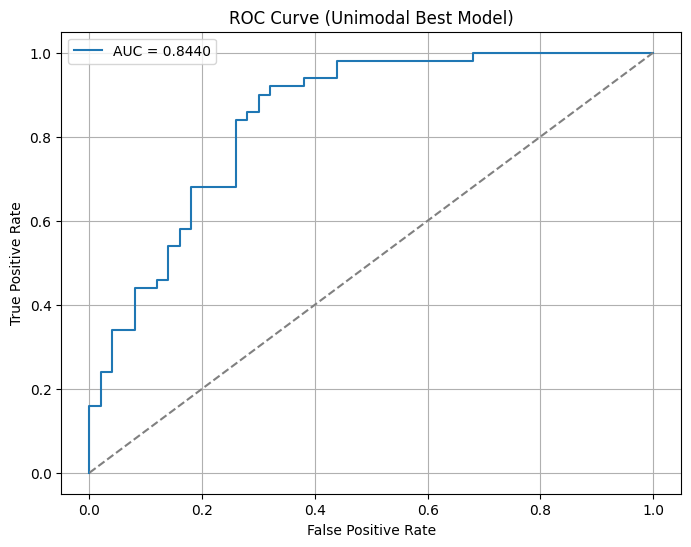

정확도 (Accuracy): 0.7800
AUC-ROC: 0.8440

분류 리포트:
              precision    recall  f1-score   support

      Normal       0.89      0.64      0.74        50
   Thickened       0.72      0.92      0.81        50

    accuracy                           0.78       100
   macro avg       0.80      0.78      0.78       100
weighted avg       0.80      0.78      0.78       100


Confusion Matrix:
[[32 18]
 [ 4 46]]


In [ ]:
import json
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 예측 결과 불러오기
with open("/content/drive/MyDrive/cv_project/01unimodal/predict_result.json", "r") as f:
    results = json.load(f)

# true, pred, prob 분리
y_true = [r["true"] for r in results]
y_pred = [r["pred"] for r in results]
y_prob = [r["prob_thickened"] for r in results]

# AUC-ROC 계산
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
auc_score = roc_auc_score(y_true, y_prob)

# ROC Curve 그리기
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Unimodal Best Model)")
plt.legend()
plt.grid()
plt.show()

# 추가 성능 출력
print(f"정확도 (Accuracy): {np.mean(np.array(y_true) == np.array(y_pred)):.4f}")
print(f"AUC-ROC: {auc_score:.4f}")
print("\n분류 리포트:")
print(classification_report(y_true, y_pred, target_names=["Normal", "Thickened"]))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))




---


## 전체 성능 요약
[단일모달 모델]
- 정확도 (Accuracy): 75.00%
- AUC-ROC: 82.58%

[이전 모델]
- 정확도 (Accuracy): 81.00%
- AUC-ROC: 89.80%

[현재 모델]
- 정확도 (Accuracy): 78.00%
- AUC-ROC: 84.40%